In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


In [11]:
df = pd.read_csv('course_lead_scoring.csv')
print(df.shape)
df.head()

(1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [12]:
target = 'converted'

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(exclude=['object']).drop(columns=[target]).columns.tolist()

print('Categorical:', categorical_cols)
print('Numerical:', numerical_cols)
df.isnull().sum()

Categorical: ['lead_source', 'industry', 'employment_status', 'location']
Numerical: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [13]:
df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numerical_cols] = df[numerical_cols].fillna(0.0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(len(df_train), len(df_val), len(df_test))

y_train = df_train[target].values
y_val = df_val[target].values
y_full_train = df_full_train[target].values
y_test = df_test[target].values

train_cols = categorical_cols + numerical_cols

X_train = df_train[train_cols].copy()
X_val = df_val[train_cols].copy()
X_full_train = df_full_train[train_cols].copy()
X_test = df_test[train_cols].copy()

876 293 293


In [15]:
roc_auc_values = {}
for col in numerical_cols:
    scores = X_train[col].values
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    roc_auc_values[col] = auc

roc_auc_values

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

In [16]:
best_feature = max(roc_auc_values, key=roc_auc_values.get)
best_feature, roc_auc_values[best_feature]

('number_of_courses_viewed', 0.7635680590007088)

In [17]:
dv = DictVectorizer(sparse=False)
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

dv.fit(train_dicts)
X_train_dv = dv.transform(train_dicts)
X_val_dv = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)

y_val_pred = model.predict_proba(X_val_dv)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
val_auc

0.8171316268814112

In [18]:
round(val_auc, 3)

0.817

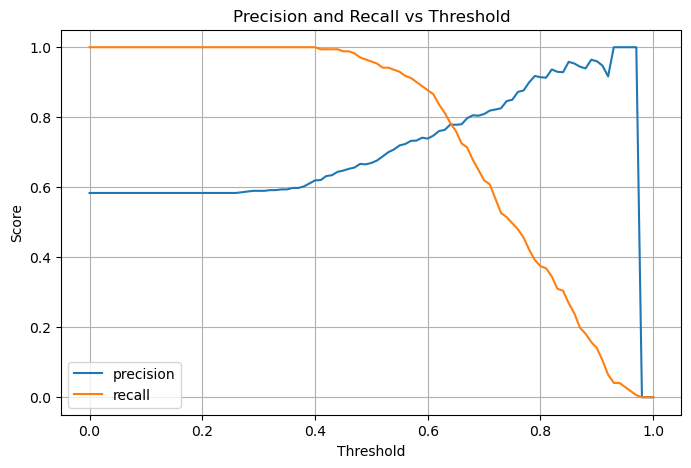

(0.98, 0.0, 0.0)

In [19]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_bin = (y_val_pred >= t).astype(int)
    precision_scores.append(precision_score(y_val, y_pred_bin, zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred_bin))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision_scores, label='precision')
plt.plot(thresholds, recall_scores, label='recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

precision_recall_diff = np.abs(np.array(precision_scores) - np.array(recall_scores))
intersection_idx = precision_recall_diff.argmin()
threshold_intersection = thresholds[intersection_idx]
threshold_intersection, precision_scores[intersection_idx], recall_scores[intersection_idx]

In [20]:
valid_mask = (np.array(precision_scores) > 0) & (np.array(recall_scores) > 0)
valid_thresholds = thresholds[valid_mask]
valid_precision = np.array(precision_scores)[valid_mask]
valid_recall = np.array(recall_scores)[valid_mask]

valid_diff = np.abs(valid_precision - valid_recall)
valid_idx = valid_diff.argmin()
intersection_threshold = valid_thresholds[valid_idx]
intersection_threshold, valid_precision[valid_idx], valid_recall[valid_idx]

(0.64, 0.7790697674418605, 0.783625730994152)

In [21]:
pr_table = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision_scores,
    'recall': recall_scores,
    'abs_diff': np.abs(np.array(precision_scores) - np.array(recall_scores))
})
pr_table.head()

,threshold,precision,recall,abs_diff
0,0.00,0.583618,1.0,0.416382
1,0.01,0.583618,1.0,0.416382
2,0.02,0.583618,1.0,0.416382
3,0.03,0.583618,1.0,0.416382
4,0.04,0.583618,1.0,0.416382


In [22]:
pr_table.loc[valid_mask, :].sort_values('abs_diff').head(10)

,threshold,precision,recall,abs_diff
64,0.64,0.779070,0.783626,0.004556
65,0.65,0.778443,0.760234,0.018209
63,0.63,0.763736,0.812865,0.049129
66,0.66,0.779874,0.725146,0.054728
62,0.62,0.760638,0.836257,0.075619
67,0.67,0.797386,0.713450,0.083935
61,0.61,0.747475,0.865497,0.118022
68,0.68,0.805556,0.678363,0.127193
60,0.60,0.738916,0.877193,0.138277
59,0.59,0.741463,0.888889,0.147425


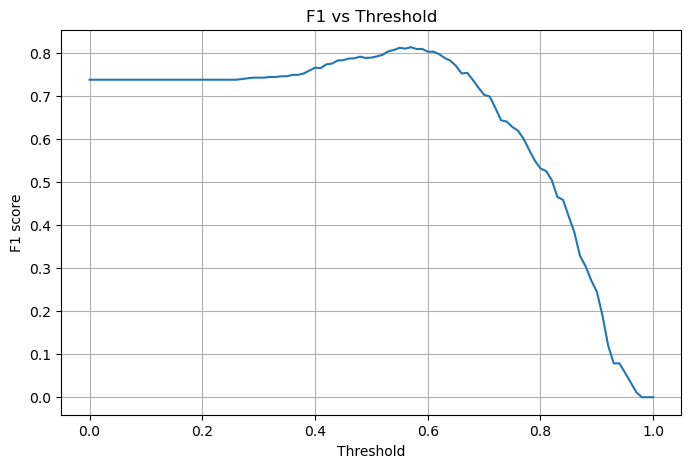

(0.5700000000000001, 0.8125)

In [23]:
f1_scores = []
for t in thresholds:
    y_pred_bin = (y_val_pred >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_bin))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()

best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]
best_f1_threshold, f1_scores[best_f1_idx]

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

fold_scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_kfold = df_full_train.iloc[train_idx]
    df_val_kfold = df_full_train.iloc[val_idx]
    
    y_train_k = df_train_kfold[target].values
    y_val_k = df_val_kfold[target].values
    
    train_dicts_k = df_train_kfold[train_cols].to_dict(orient='records')
    val_dicts_k = df_val_kfold[train_cols].to_dict(orient='records')
    
    dv_k = DictVectorizer(sparse=False)
    X_train_k = dv_k.fit_transform(train_dicts_k)
    X_val_k = dv_k.transform(val_dicts_k)
    
    model_k = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_k.fit(X_train_k, y_train_k)
    y_val_pred_k = model_k.predict_proba(X_val_k)[:, 1]
    auc_k = roc_auc_score(y_val_k, y_val_pred_k)
    fold_scores.append(auc_k)

fold_scores, np.mean(fold_scores), np.std(fold_scores)

([0.8060745924216483,
  0.8713738368910783,
  0.7754320118852139,
  0.8018368617683685,
  0.8558272713202291],
 0.8221089148573075,
 0.03580711942905165)

In [25]:
Cs = [0.000001, 0.001, 1]
results = []
for C in Cs:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_kfold = df_full_train.iloc[train_idx]
        df_val_kfold = df_full_train.iloc[val_idx]

        y_train_k = df_train_kfold[target].values
        y_val_k = df_val_kfold[target].values

        train_dicts_k = df_train_kfold[train_cols].to_dict(orient='records')
        val_dicts_k = df_val_kfold[train_cols].to_dict(orient='records')

        dv_k = DictVectorizer(sparse=False)
        X_train_k = dv_k.fit_transform(train_dicts_k)
        X_val_k = dv_k.transform(val_dicts_k)

        model_k = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_k.fit(X_train_k, y_train_k)
        y_val_pred_k = model_k.predict_proba(X_val_k)[:, 1]
        auc_k = roc_auc_score(y_val_k, y_val_pred_k)
        scores.append(auc_k)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append({'C': C, 'mean_auc': mean_score, 'std_auc': std_score})

results_df = pd.DataFrame(results)
results_df['mean_auc_round'] = results_df['mean_auc'].round(3)
results_df['std_auc_round'] = results_df['std_auc'].round(3)
results_df

,C,mean_auc,std_auc,mean_auc_round,std_auc_round
0,0.000001,0.560208,0.023798,0.560,0.024
1,0.001000,0.866878,0.028746,0.867,0.029
2,1.000000,0.822109,0.035807,0.822,0.036


In [26]:
best_row = results_df.sort_values(['mean_auc', 'std_auc', 'C'], ascending=[False, True, True]).iloc[0]
best_row['C'], best_row['mean_auc'], best_row['std_auc']

(0.001, 0.8668780317675395, 0.028746230508215103)